In [1]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

2024-03-01 17:59:35.745896: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 17:59:35.746085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 17:59:35.930946: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
datadir = '/kaggle/input/weather-dataset/dataset'

# Exploring the dataset

In [3]:
climates = {cl: len(os.listdir(os.path.join(datadir, cl))) for cl in os.listdir(datadir)}

<Axes: >

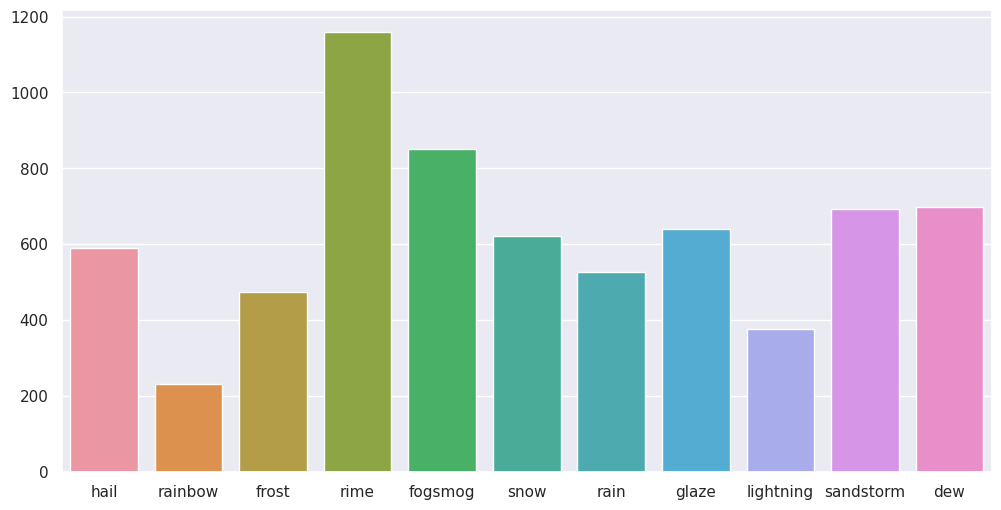

In [4]:
sns.set(rc={"figure.figsize":(12, 6)})
sns.barplot(x=list(climates.keys()), y=list(climates.values()))

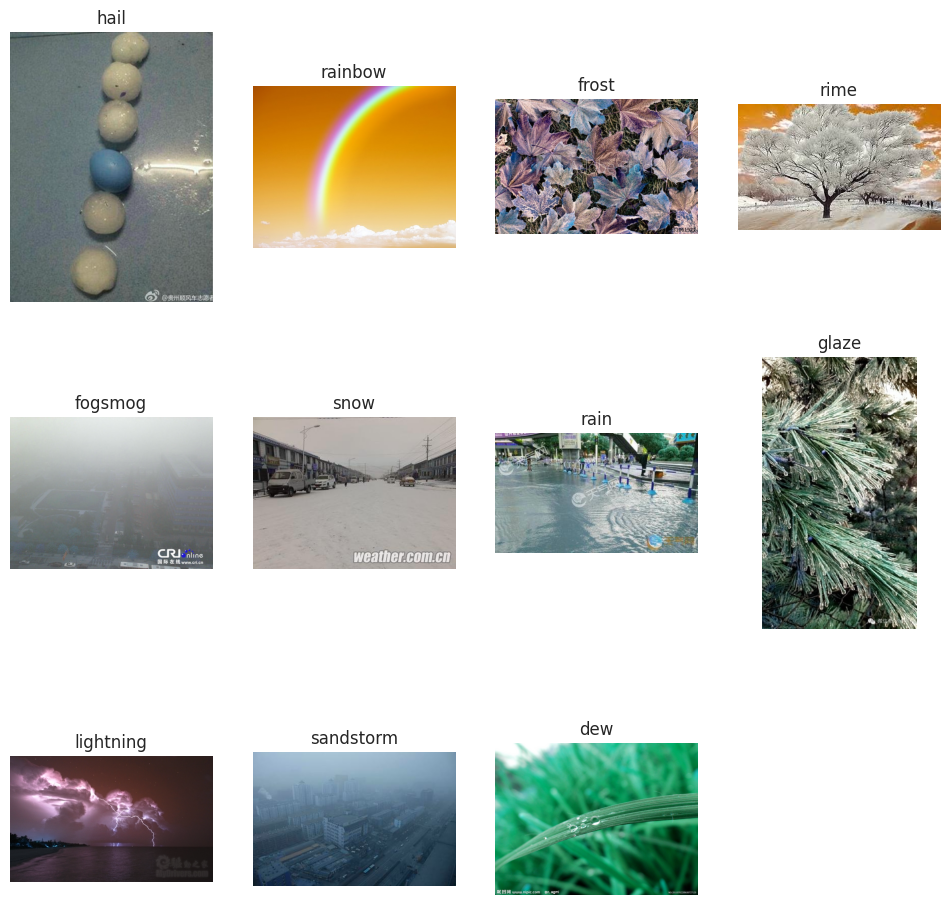

In [5]:
fig = plt.figure(figsize=(12, 12)) 
rows = 3
columns = 4

for i, cl in enumerate(climates.keys()):
    img_name = os.listdir(os.path.join(datadir, cl))[random.randrange(0, 100)]
    img_path = os.path.join(datadir, cl, img_name)
    img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
    fig.add_subplot(rows, columns, i+1) 
    plt.axis('off') 
    plt.imshow(img)
    plt.title(cl)
plt.show()

# Preprocessing Images